# Game of Thrones, Twitter, and Text Analysis by Kaba Haou for DSCI 311 

In this assignment, I will work with Twitter data in order to analyze ~20,000 tweets about the final season of Game of Thrones. The goal is to deconstruct tweets into their individual words and assign a sentiment score to each, evaluating the overall sentiment of each tweet toward Game of Thrones.


In [1]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

In [3]:
got = pd.read_csv("/Users/kaba/Projects/gotTwitter.csv")
got.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width
0,x427124533,x1120174512736280577,4/22/2019 3:56,WOMAXO,So Game of Thrones is just basically about who<U+2019>s gonna be the next Hokage?,Twitter for iPhone,74
1,x949794998010163200,x1117612261806419975,4/15/2019 2:15,BbalEvv,"Is Game of Thrones really that good? Man, it is mentioned anywhere you look today. \n\nWhat’s the big deal? \n\nIs it as good as Billions? We are in the middle of that series. Game of Thrones can’t be as good as Billions. \n\nJust can’t be.",Twitter for iPhone,240
2,x281627203,x1126361110246879232,5/9/2019 5:39,Krachtworks,@ThomasLBarr This is some game of thrones action right here. #TempeThrone,Twitter for iPhone,60
3,x168322273,x1125175463549198337,5/5/2019 23:08,MrCamW,"Before more fan faves potentially perish (?) today, here's my piece on the morality of 'Game of Thrones' and leadership https://t.co/uhPfCoQMeP",Twitter Web Client,143
4,x1472761238,x1128279188786511872,5/14/2019 12:41,jeniecet,Game of Thrones episode 1 season 1. <U+0001F643>,Twitter for iPhone,37


Creating barplot to identify the 10 most used devices/apps more broadly "sources" of the tweet data

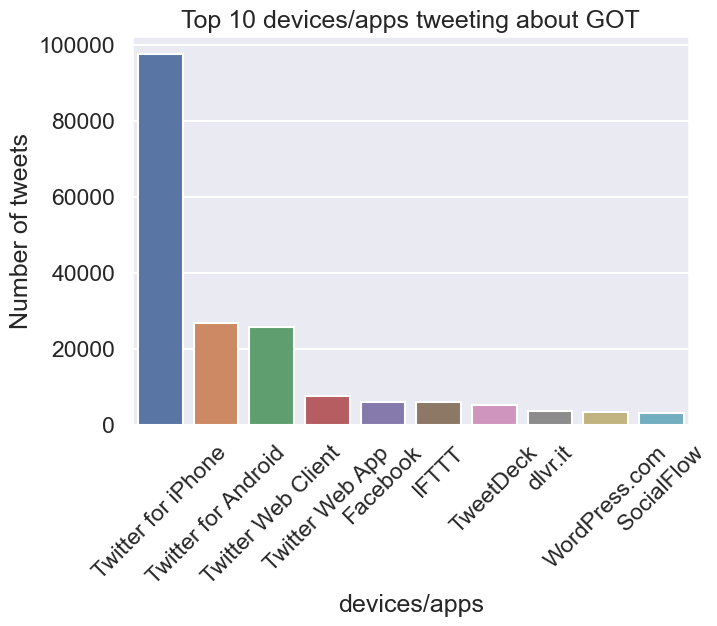

In [4]:
num_occurences = got['source'].value_counts()
top_ten = num_occurences[:10]
sns.barplot(x=top_ten.index, y=top_ten.values)
plt.xticks(rotation=45)
plt.xlabel('devices/apps')
plt.ylabel('Number of tweets')
plt.title('Top 10 devices/apps tweeting about GOT')
plt.show()


This data represents tweets across the relase window of all 6 final episodes of the Game of Thrones series. I want to see if I can incurr when the episodes were released based on frequency of tweets. I'll convert created_at into a datetime object using a pandas function. 

In [5]:
got["created_at"] = pd.to_datetime(got["created_at"])
got.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width
0,x427124533,x1120174512736280577,2019-04-22 03:56:00,WOMAXO,So Game of Thrones is just basically about who<U+2019>s gonna be the next Hokage?,Twitter for iPhone,74
1,x949794998010163200,x1117612261806419975,2019-04-15 02:15:00,BbalEvv,"Is Game of Thrones really that good? Man, it is mentioned anywhere you look today. \n\nWhat’s the big deal? \n\nIs it as good as Billions? We are in the middle of that series. Game of Thrones can’t be as good as Billions. \n\nJust can’t be.",Twitter for iPhone,240
2,x281627203,x1126361110246879232,2019-05-09 05:39:00,Krachtworks,@ThomasLBarr This is some game of thrones action right here. #TempeThrone,Twitter for iPhone,60
3,x168322273,x1125175463549198337,2019-05-05 23:08:00,MrCamW,"Before more fan faves potentially perish (?) today, here's my piece on the morality of 'Game of Thrones' and leadership https://t.co/uhPfCoQMeP",Twitter Web Client,143
4,x1472761238,x1128279188786511872,2019-05-14 12:41:00,jeniecet,Game of Thrones episode 1 season 1. <U+0001F643>,Twitter for iPhone,37


Identifying the timespan of the dates on our tweet data

In [6]:
start = got["created_at"].min()
end = got["created_at"].max()
start, end

(Timestamp('2019-04-07 14:50:00'), Timestamp('2019-05-28 02:59:00'))

Creating histogram of converted datetime column.

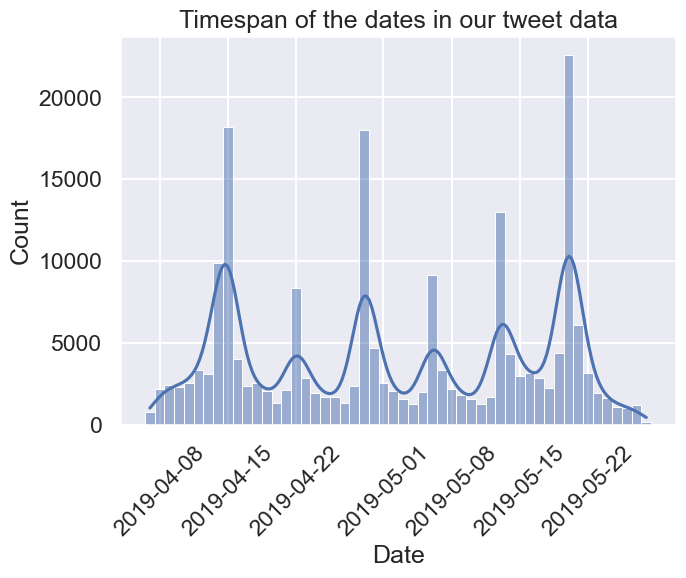

In [7]:
got['date'] = got['created_at'].dt.date
sns.histplot(data=got, x='date', bins=5, kde=True)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Timespan of the dates in our tweet data')
plt.show()

Plotting 3 overlapping KDE plots, representing the 3 main sources for tweets

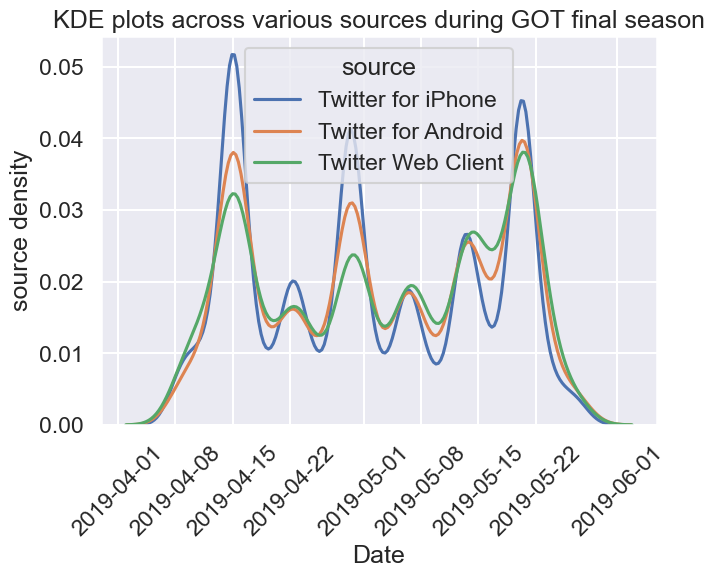

In [8]:
grouped = got.groupby('source')
iphone = grouped.get_group('Twitter for iPhone')
android = grouped.get_group('Twitter for Android')
web = grouped.get_group('Twitter Web Client')
sns.kdeplot(data=iphone, x='created_at')
sns.kdeplot(data=android, x='created_at')
sns.kdeplot(data=web, x='created_at')
plt.xticks(rotation=45)
plt.ylabel('source density')
plt.xlabel('Date')
plt.title('KDE plots across various sources during GOT final season')
label = ['Twitter for iPhone', 'Twitter for Android', 'Twitter Web Client']
plt.legend(title='source', labels=label, loc='best')
plt.show()


I will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of our tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage. The VADER lexicon gives the sentiment of individual words. 

Reading in the dictionary of characters along with the polarity score associated into columns word and polarity

In [15]:
#col_names = ['word', 'polarity']
sent = pd.read_csv('/Users/kaba/Projects/vader_lexicon.txt', sep='\t', header=None)
sent.columns = ['word', 'polarity', 'weird', 'strange']
#sent = sent.set_index('word')
sent = sent.drop(columns=['weird', 'strange'])
sent.head()

,word,polarity
0,$:,-1.5
1,%),-0.4
2,%-),-1.5
3,&-:,-0.4
4,&:,-0.7


Cleaning text data by removing characters that will interfere with the analysis.

In [16]:
got["text"] = got['text'].str.replace('[#@\n]', '', regex=True)
got[50:100]

,user_id,status_id,created_at,screen_name,text,source,display_text_width,date,words
50,x1093353504830308355,x1117555567923539970,2019-04-14 22:29:00,MrEasilyOffened,why watch game of thrones when you can just watch seinfeld for the hundredth time,Twitter for Android,84,2019-04-14,"[why, watch, game, of, thrones, when, you, can, just, watch, seinfeld, for, the, hundredth, time]"
51,x2291838379,x1125419982349905920,2019-05-06 15:20:00,FashionPourElle,fashiongeorge r r martin confirms three game of thrones pourelles,Stars TVMag,98,2019-05-06,"[fashiongeorge, r, r, martin, confirms, three, game, of, thrones, pourelles]"
52,x1021811433275883520,x1122954907340935175,2019-04-29 20:04:00,kiannastweets,was so distracted by endgame amp game of thrones that i completely forgot attack on titan came back on,Twitter for iPhone,107,2019-04-29,"[was, so, distracted, by, endgame, amp, game, of, thrones, that, i, completely, forgot, attack, on, titan, came, back, on]"
53,x119959974,x1116736513289666560,2019-04-12 16:15:00,cachiloreto,i love a medieval family drama heres hoping game of thrones embraces its familydrama roots in season column via variety,Twitter Web Client,159,2019-04-12,"[i, love, a, medieval, family, drama, heres, hoping, game, of, thrones, embraces, its, familydrama, roots, in, season, column, via, variety]"
54,x143686967,x1118168195490123776,2019-04-16 15:04:00,hypercubexl,not quite the breakdowns of software and rendering i am after but its nice for the thought behind it all,Twitter for Android,130,2019-04-16,"[not, quite, the, breakdowns, of, software, and, rendering, i, am, after, but, its, nice, for, the, thought, behind, it, all]"
55,x298790074,x1120175795614420992,2019-04-22 04:01:00,alie_ohh,everyone in this dimension has their priorities out of whack like ok fine game of thrones but hello the oa,Twitter for iPhone,110,2019-04-22,"[everyone, in, this, dimension, has, their, priorities, out, of, whack, like, ok, fine, game, of, thrones, but, hello, the, oa]"
56,x2729619988,x1124469613687922688,2019-05-04 00:23:00,tinabruh,where can i watch game of thrones on my laptop i donut wanna get a virus please help,Twitter for iPhone,87,2019-05-04,"[where, can, i, watch, game, of, thrones, on, my, laptop, i, donut, wanna, get, a, virus, please, help]"
57,x1027021692,x1129487089337339905,2019-05-17 20:41:00,han_noble,how am i preparing for the final episode of game of thrones by rewatching the whole series of course,Twitter Web App,102,2019-05-17,"[how, am, i, preparing, for, the, final, episode, of, game, of, thrones, by, rewatching, the, whole, series, of, course]"
58,x2967693550,x1123048907016163329,2019-04-30 02:18:00,dopest_squally,ium trynna think who else has green eyes in game of thrones ufuf,Twitter for iPhone,62,2019-04-30,"[ium, trynna, think, who, else, has, green, eyes, in, game, of, thrones, ufuf]"
59,x2883398314,x1132114126510149633,2019-05-25 02:40:00,ricardojames51,liked on youtube chinaus ucgame of thronesud gambit amp ben carsonus ucoreoud gaffe the daily show,IFTTT,123,2019-05-25,"[liked, on, youtube, chinaus, ucgame, of, thronesud, gambit, amp, ben, carsonus, ucoreoud, gaffe, the, daily, show]"


Cleaning the text field by removing the URLs from each text entry

In [17]:
def remove_url(string):
    url = r'https?://\S+|www\.\S+'
    return re.sub(url, '', string)
    
got["text"] = got['text'].apply(remove_url)
got

,user_id,status_id,created_at,screen_name,text,source,display_text_width,date,words
0,x427124533,x1120174512736280577,2019-04-22 03:56:00,WOMAXO,so game of thrones is just basically about whous gonna be the next hokage,Twitter for iPhone,74,2019-04-22,"[so, game, of, thrones, is, just, basically, about, whous, gonna, be, the, next, hokage]"
1,x949794998010163200,x1117612261806419975,2019-04-15 02:15:00,BbalEvv,is game of thrones really that good man it is mentioned anywhere you look today whats the big deal is it as good as billions we are in the middle of that series game of thrones cant be as good as billions just cant be,Twitter for iPhone,240,2019-04-15,"[is, game, of, thrones, really, that, good, man, it, is, mentioned, anywhere, you, look, today, whats, the, big, deal, is, it, as, good, as, billions, we, are, in, the, middle, of, that, series, game, of, thrones, cant, be, as, good, as, billions, just, cant, be]"
2,x281627203,x1126361110246879232,2019-05-09 05:39:00,Krachtworks,thomaslbarr this is some game of thrones action right here tempethrone,Twitter for iPhone,60,2019-05-09,"[thomaslbarr, this, is, some, game, of, thrones, action, right, here, tempethrone]"
3,x168322273,x1125175463549198337,2019-05-05 23:08:00,MrCamW,before more fan faves potentially perish today heres my piece on the morality of game of thrones and leadership,Twitter Web Client,143,2019-05-05,"[before, more, fan, faves, potentially, perish, today, heres, my, piece, on, the, morality, of, game, of, thrones, and, leadership]"
4,x1472761238,x1128279188786511872,2019-05-14 12:41:00,jeniecet,game of thrones episode season uf,Twitter for iPhone,37,2019-05-14,"[game, of, thrones, episode, season, uf]"
...,...,...,...,...,...,...,...,...,...
204539,x102141815,x1117593233436098561,2019-04-15 00:59:00,ssomers55,game of thrones starts in mins and it is mins till and it bothers me,Twitter for Android,74,2019-04-15,"[game, of, thrones, starts, in, mins, and, it, is, mins, till, and, it, bothers, me]"
204540,x512330406,x1127815256166760449,2019-05-13 05:58:00,Siegfriend17,people seem to have forgotten what game of thrones is,Twitter for Android,53,2019-05-13,"[people, seem, to, have, forgotten, what, game, of, thrones, is]"
204541,x375024785,x1128840645039329280,2019-05-16 01:52:00,SciclunaGson,the game of thrones theme song custom shop fender via youtube,Twitter for iPhone,90,2019-05-16,"[the, game, of, thrones, theme, song, custom, shop, fender, via, youtube]"
204542,x104545031,x1130331531531177985,2019-05-20 04:36:00,PvJeeJ,game of thrones chocked,Twitter for iPhone,24,2019-05-20,"[game, of, thrones, chocked]"


Cleaning data set by removing any unusual characters(like emojis used on twitter) and punctuation, things that won't be useful for the sentiment analysis. Then standardizing the charcaters by making them all lower case.

In [18]:
def remove_unusual(string):
    return re.sub(r'[^a-zA-Z\s]', '', string)
got["text"] = got['text'].apply(remove_unusual)
got['text'] = got['text'].apply(str.lower)
got.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,date,words
0,x427124533,x1120174512736280577,2019-04-22 03:56:00,WOMAXO,so game of thrones is just basically about whous gonna be the next hokage,Twitter for iPhone,74,2019-04-22,"[so, game, of, thrones, is, just, basically, about, whous, gonna, be, the, next, hokage]"
1,x949794998010163200,x1117612261806419975,2019-04-15 02:15:00,BbalEvv,is game of thrones really that good man it is mentioned anywhere you look today whats the big deal is it as good as billions we are in the middle of that series game of thrones cant be as good as billions just cant be,Twitter for iPhone,240,2019-04-15,"[is, game, of, thrones, really, that, good, man, it, is, mentioned, anywhere, you, look, today, whats, the, big, deal, is, it, as, good, as, billions, we, are, in, the, middle, of, that, series, game, of, thrones, cant, be, as, good, as, billions, just, cant, be]"
2,x281627203,x1126361110246879232,2019-05-09 05:39:00,Krachtworks,thomaslbarr this is some game of thrones action right here tempethrone,Twitter for iPhone,60,2019-05-09,"[thomaslbarr, this, is, some, game, of, thrones, action, right, here, tempethrone]"
3,x168322273,x1125175463549198337,2019-05-05 23:08:00,MrCamW,before more fan faves potentially perish today heres my piece on the morality of game of thrones and leadership,Twitter Web Client,143,2019-05-05,"[before, more, fan, faves, potentially, perish, today, heres, my, piece, on, the, morality, of, game, of, thrones, and, leadership]"
4,x1472761238,x1128279188786511872,2019-05-14 12:41:00,jeniecet,game of thrones episode season uf,Twitter for iPhone,37,2019-05-14,"[game, of, thrones, episode, season, uf]"


Converting the tweets into a tidier format to make sentiments easier to calculate. Doing so by creating new dataframe "tidy_got" with three columns id: containing the id of the tweet which can contain any value 0-n unique tweets, num: The location of the word in the tweet index starting from 0, and word: the individual words of each tweet. 

In [19]:
tidy_got = got['text'].str.split().explode().reset_index()
tidy_got.columns = ['id', 'word']
tidy_got = tidy_got.set_index('id')
tidy_got['num'] = range(len(tidy_got))
tidy_got.head()

,word,num
id,,
0,so,0
0,game,1
0,of,2
0,thrones,3
0,is,4


Adding a column "polarity" to the got dataframe which contains the sum of the sentiment polarity of each word in the text of the tweet.

In [20]:
got['words'] = got['text'].str.split()
def calc_polarity(words):
   return sum(sent[sent['word'].isin(words)]['polarity'])
got['polarity'] = got['words'].apply(calc_polarity)
got.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,date,words,polarity
0,x427124533,x1120174512736280577,2019-04-22 03:56:00,WOMAXO,so game of thrones is just basically about whous gonna be the next hokage,Twitter for iPhone,74,2019-04-22,"[so, game, of, thrones, is, just, basically, about, whous, gonna, be, the, next, hokage]",0.0
1,x949794998010163200,x1117612261806419975,2019-04-15 02:15:00,BbalEvv,is game of thrones really that good man it is mentioned anywhere you look today whats the big deal is it as good as billions we are in the middle of that series game of thrones cant be as good as billions just cant be,Twitter for iPhone,240,2019-04-15,"[is, game, of, thrones, really, that, good, man, it, is, mentioned, anywhere, you, look, today, whats, the, big, deal, is, it, as, good, as, billions, we, are, in, the, middle, of, that, series, game, of, thrones, cant, be, as, good, as, billions, just, cant, be]",1.9
2,x281627203,x1126361110246879232,2019-05-09 05:39:00,Krachtworks,thomaslbarr this is some game of thrones action right here tempethrone,Twitter for iPhone,60,2019-05-09,"[thomaslbarr, this, is, some, game, of, thrones, action, right, here, tempethrone]",0.0
3,x168322273,x1125175463549198337,2019-05-05 23:08:00,MrCamW,before more fan faves potentially perish today heres my piece on the morality of game of thrones and leadership,Twitter Web Client,143,2019-05-05,"[before, more, fan, faves, potentially, perish, today, heres, my, piece, on, the, morality, of, game, of, thrones, and, leadership]",1.3
4,x1472761238,x1128279188786511872,2019-05-14 12:41:00,jeniecet,game of thrones episode season uf,Twitter for iPhone,37,2019-05-14,"[game, of, thrones, episode, season, uf]",0.0


Looking at the tweets with the highest and lowest polarity scores to verify that the tweets are accurately represented by their polarity scores. As you'll see polarity score of a tweet doesn't always associate with the show itself. The third tweet in the most negative group which describes the violence and brutality that occurs in the show, but doesn't have any truly negative sentiment towards the show itself. That is something to note generally when conducting sentiment analysis. 

In [21]:
print('Most negative tweets:')
for t in got.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   worst episode of game of thronesthe writing is so weak they skipped words and ran out of the clock with repetitive violence i hope people take one thing away from it  war is hell and politicians that want war are the enemy of us allbush and obama destroyed countries

   he killed his father choked a women till she died killed people on black water battle and played hard the game of thrones but wait hes a man so he cannont be a shit person just a woman goes mad when she fights for what she believes gameofthrones ended up disgusting 

   seriously this is a show that depicts characters moving on from rape torture dismemberment paralysis enduring tyrants slavery watching family get murdered and battling zombies but irl gameofthrones ending is the trauma people cant handle uf 

   i dont know that its lazy writing the more i think about it dany has killed crucified amp tortured innocent people in the past maybe the point is anyone who lusts for power ends up just 

In [22]:
print('Most positive tweets:')
for t in got.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   the new game of thrones was so good  in excited for next sunday now relaxed on the couch watching crazy rich asians which i has heard of but never seen till now my friend put it on since she likes it its pretty alright so far funny lol

   well that will wrap up game of thrones for me was an amazing show and im glad theres no more cliff hangers to wait for lol not the best season but not that bad come on i will say this last season or two seemed a bit rushed but oh well i enjoyed myself xd ggs got

   game of thrones ruled this week i love varys so much honestly one of the best characters on the show i still hope cersei wins lol

   good morning yall happy sunday yall know what day it is game of thrones im so excited lmao  but anyways good morning yall i hope everyone has a pleasant and safe end to yall weekend goodmorning gameofthrones  housetargaryen targaryen 

   themikelawrence maestrodane or give that chance to  talented writer who can come up with a bet

**Plot analysis:** The kde plot for Jaime is the most

Visualizing the tweet sentiment for 3 prominent characters in the GOT television series with a KDE plot

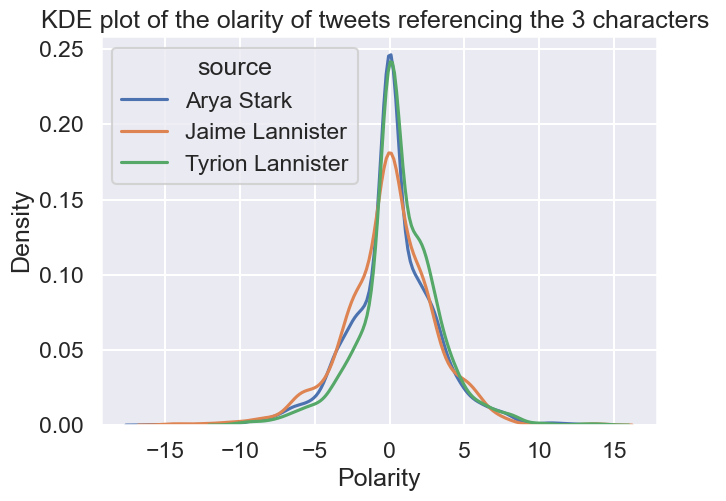

In [23]:
arya = got[got['words'].apply(lambda x: 'arya' in x)]
jaime = got[got['words'].apply(lambda x: 'jaime' in x)]
tyrion = got[got['words'].apply(lambda x: 'tyrion' in x)]
sns.kdeplot(data=arya, x='polarity')
sns.kdeplot(data=jaime, x='polarity')
sns.kdeplot(data=tyrion, x='polarity')
plt.ylabel('Density')
plt.xlabel('Polarity')
plt.title('KDE plot of the olarity of tweets referencing the 3 characters ')
label = ['Arya Stark', 'Jaime Lannister', 'Tyrion Lannister']
plt.legend(title='source', labels=label, loc='best')
plt.show()


**Plot analysis:** The kde plot for Jaime is the most negative (unsuprisingly lol) out of the three characters I chose, with a failry symmetrical distribution with a slight lean to the left. Jaime also isn't referenced as much as the two other characters as you can see with the height of his curve. Arya and Tyrion have a similar amount of mentions in tweets with their curve peaking at a density if just under 0.25. Tyrion appears to have slightly more positive sentiment than arya, who is extremely neutral. I think the curves suggest that arya and tyrion are extremely popular characters, with Jaime's popularity to a lesser degree. Arya overall has a neutral sentiment, Tyrion has a slightly positive sentiment, while Jaime's sentiment is slightly negative. 